In [1]:
%load_ext autoreload
%autoreload 2

from context import uncertify

In [2]:
import logging
from uncertify.log import setup_logging
setup_logging()
LOG = logging.getLogger(__name__)

# Matplotlib DEBUG logging spits out a whole bunch of crap
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.ERROR)

In [3]:
from pathlib import Path

from torch.utils.data import DataLoader
import torchvision

from uncertify.models.vae import load_vae_baur_model
from uncertify.data.dataloaders import DatasetType
from uncertify.data.dataloaders import dataloader_factory
from uncertify.evaluation.evaluation_pipeline import run_evaluation_pipeline
from uncertify.evaluation.configs import EvaluationConfig, PerformanceEvaluationConfig, PixelThresholdSearchConfig
from uncertify.data.datasets import GaussianNoiseDataset
from uncertify.common import DATA_DIR_PATH

In [32]:
# Define some paths and high level parameters
CHECKPOINT_PATH = Path('/media/juniors/2TB_internal_HD/lightning_logs/train_vae/version_3/checkpoints/last.ckpt')
HDD_PROCESSED_DIR_PATH = Path('/media/juniors/2TB_internal_HD/datasets/processed/')
BATCH_SIZE = 155
USE_N_BATCHES = 20

# Load the model and define the evaluation config
model = load_vae_baur_model(CHECKPOINT_PATH)
eval_cfg = EvaluationConfig()
eval_cfg.use_n_batches = USE_N_BATCHES

# Define all dataloaders
_, brats_val_t2_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=BATCH_SIZE, 
                                             val_set_path=HDD_PROCESSED_DIR_PATH / 'brats17_t2_hm_bc_std_bv-3.5.hdf5', shuffle_val=False)
_, brats_val_t1_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=BATCH_SIZE, 
                                             val_set_path=HDD_PROCESSED_DIR_PATH / 'brats17_t1_hm_bc_std_bv-3.5.hdf5', shuffle_val=False)

camcan_train_dataloader, camcan_val_dataloader = dataloader_factory(DatasetType.CAMCAN, batch_size=BATCH_SIZE, 
                                                                    val_set_path=DATA_DIR_PATH / 'processed/camcan_val_t2_hm_std_bv3.5_xe.hdf5', 
                                                                    train_set_path=DATA_DIR_PATH / 'processed/camcan_train_t2_hm_std_bv3.5_xe.hdf5', 
                                                                    shuffle_val=False, shuffle_train=True)
noise_set = GaussianNoiseDataset()
noise_loader = DataLoader(noise_set, batch_size=BATCH_SIZE)

_, mnist_val_dataloader = dataloader_factory(DatasetType.MNIST, batch_size=BATCH_SIZE, transform=torchvision.transforms.Compose([
                                                                        torchvision.transforms.Resize((128, 128)),
                                                                        torchvision.transforms.ToTensor()]))

2020-10-30 13:48:57,540 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating segmentation (DICE / IOU) performance for residual thresholds: [0.0, 0.75, 1.5, 2.25, 3.0]


Inferring batches : 21it [01:00,  2.87s/it]                        
Inferring batches : 21it [00:59,  2.85s/it]                        
Inferring batches : 21it [00:59,  2.83s/it]                        
Inferring batches : 21it [00:59,  2.85s/it]                        
Inferring batches : 21it [01:00,  2.88s/it]                        
Inferring batches : 21it [00:59,  2.84s/it]                        

2020-10-30 13:54:56,905 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating pixel-wise anomaly detection performance (ROC, PRC)...



Inferring batches : 21it [01:01,  2.91s/it]                        


dict_keys(['REC_TERM', 'KL_TERM', 'ELBO'])
REC_TERM
SliceWiseCriteria.REC_TERM
KL_TERM
SliceWiseCriteria.KL_TERM
ELBO
SliceWiseCriteria.ELBO
2020-10-30 13:56:32,684 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating slice-wise anomaly detection performance (ROC, PRC)...
26388
26388
26388
2020-10-30 13:56:35,269 : uncertify.evaluation.evaluation_pipeline : INFO       Producing model statistics histograms...


Inferring batches training set: 21it [01:04,  3.05s/it]                        
Inferring batches validation set: 21it [00:59,  2.83s/it]                        


2020-10-30 13:58:39,570 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating segmentation (DICE / IOU) performance for residual thresholds: [0.0, 0.75, 1.5, 2.25, 3.0]


Inferring batches : 21it [01:00,  2.90s/it]                        
Inferring batches : 21it [01:01,  2.92s/it]                        
Inferring batches : 21it [00:59,  2.85s/it]                        
Inferring batches : 21it [01:00,  2.86s/it]                        
Inferring batches : 21it [01:00,  2.86s/it]                        
Inferring batches : 21it [00:59,  2.84s/it]                        

2020-10-30 14:04:41,632 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating pixel-wise anomaly detection performance (ROC, PRC)...



Inferring batches : 21it [01:01,  2.91s/it]                        


dict_keys(['REC_TERM', 'KL_TERM', 'ELBO'])
REC_TERM
SliceWiseCriteria.REC_TERM
KL_TERM
SliceWiseCriteria.KL_TERM
ELBO
SliceWiseCriteria.ELBO
2020-10-30 14:06:17,571 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating slice-wise anomaly detection performance (ROC, PRC)...
35688
35688
35688


/home/juniors/code/uncertify/uncertify/visualization/plotting.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=kwargs.get('figsize'))


2020-10-30 14:06:20,702 : uncertify.evaluation.evaluation_pipeline : INFO       Producing model statistics histograms...


Inferring batches training set: 21it [01:01,  2.93s/it]                        
Inferring batches validation set: 21it [00:57,  2.75s/it]                        


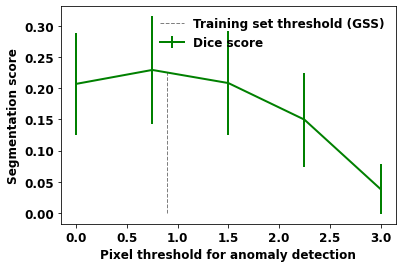

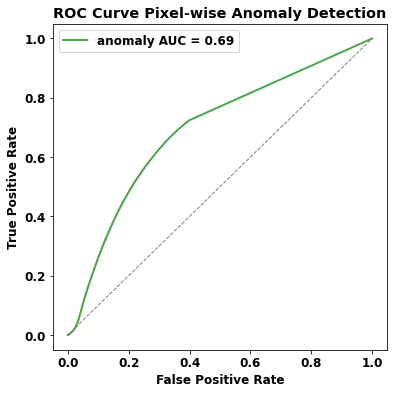

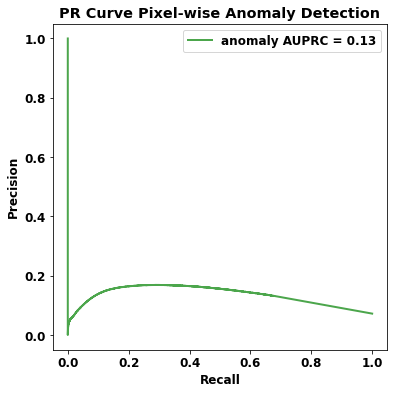

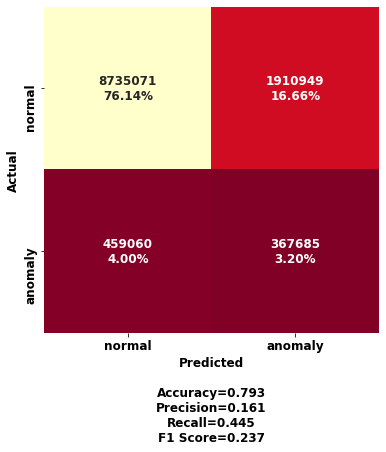

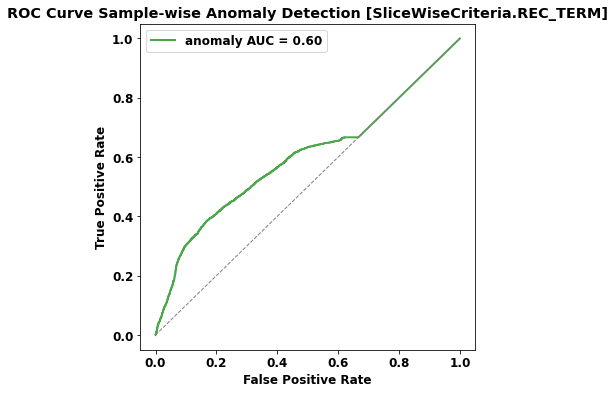

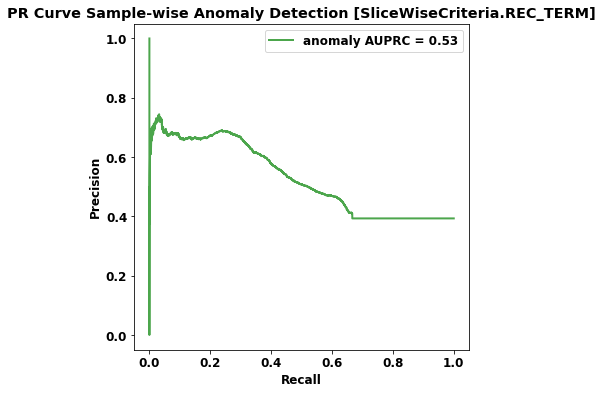

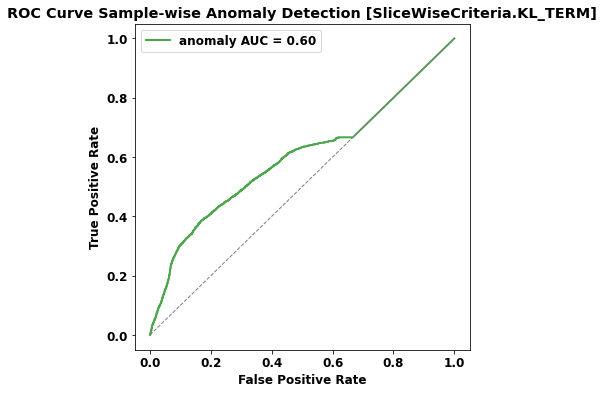

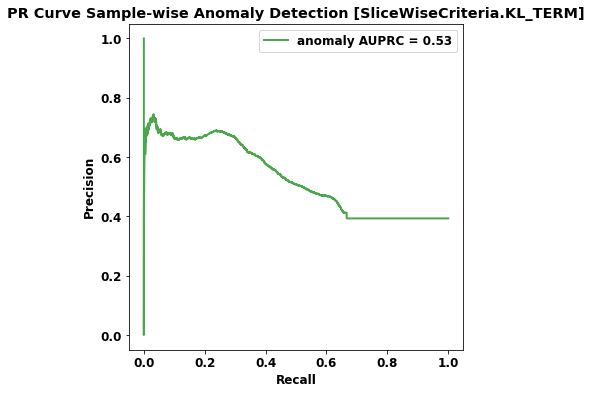

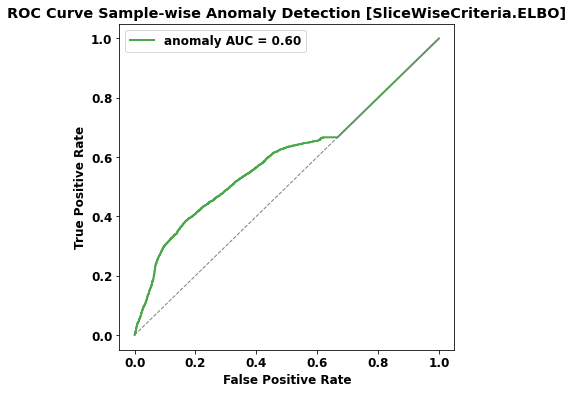

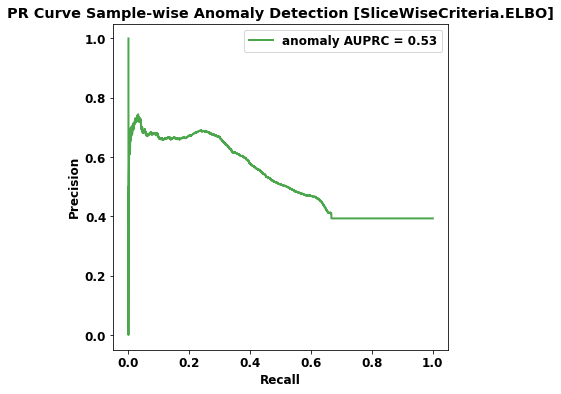

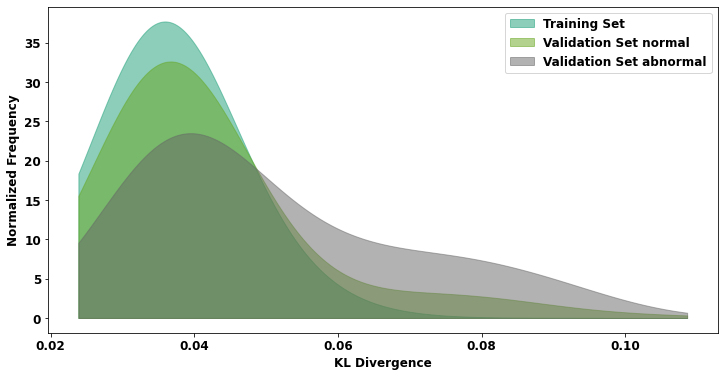

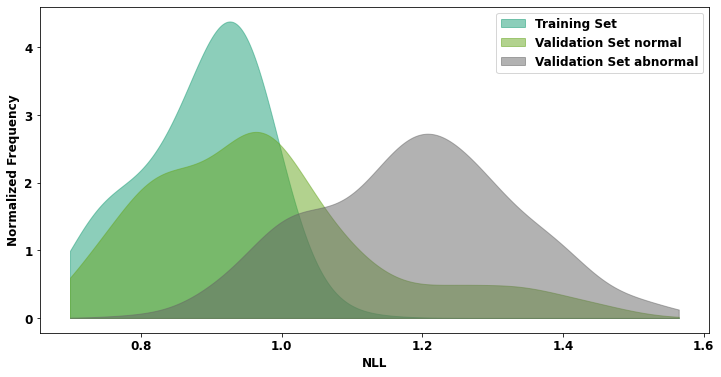

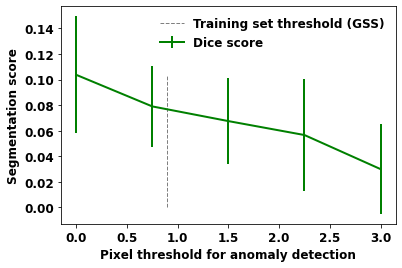

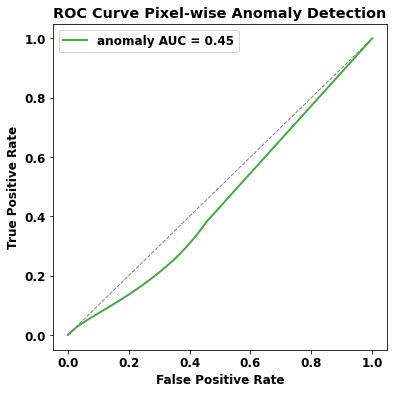

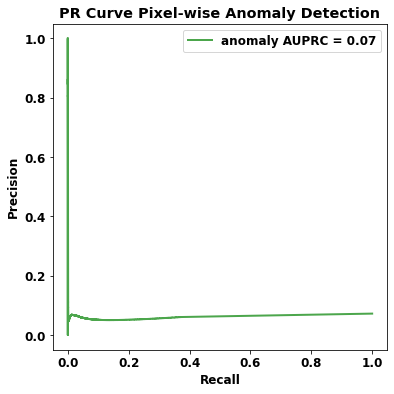

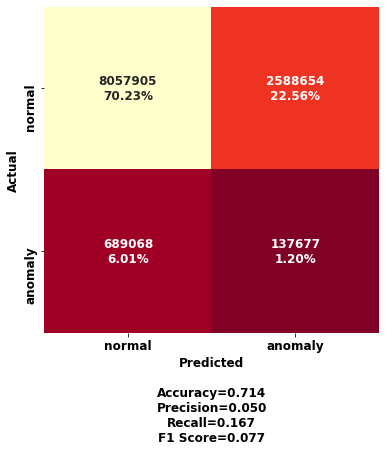

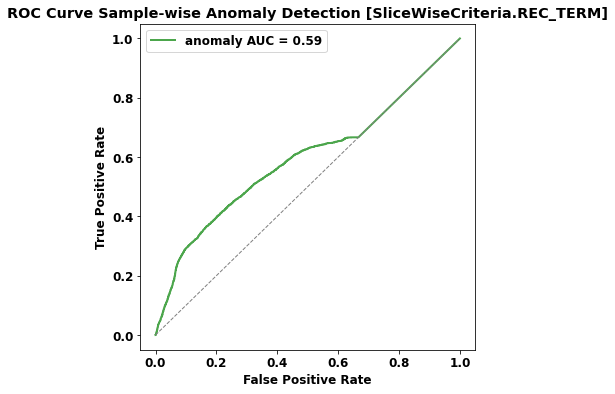

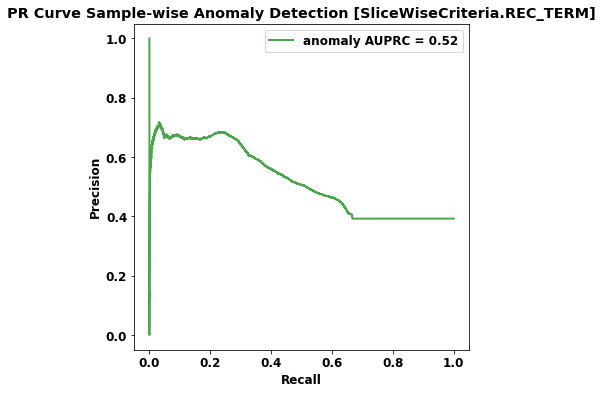

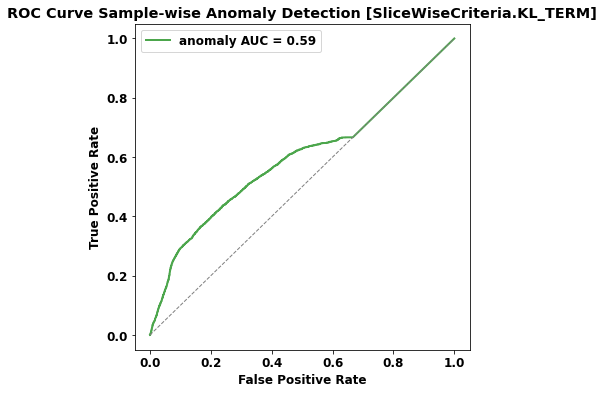

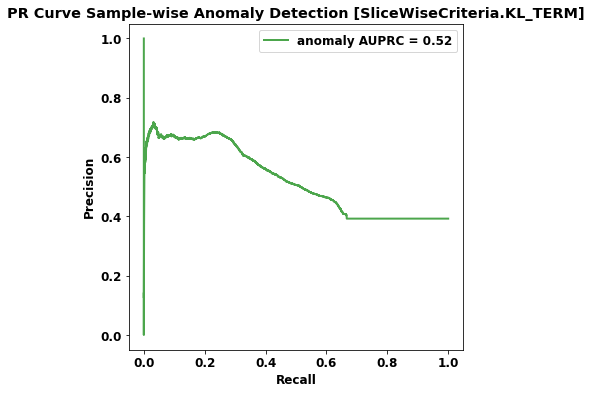

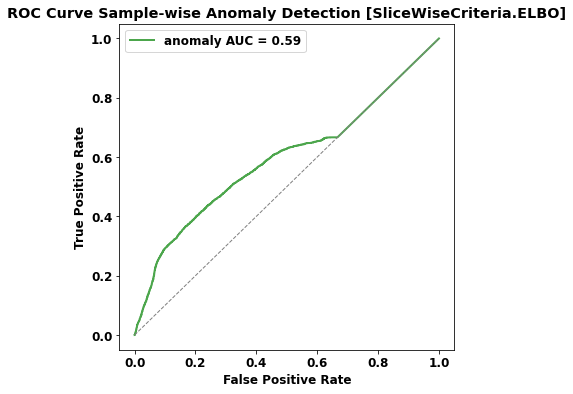

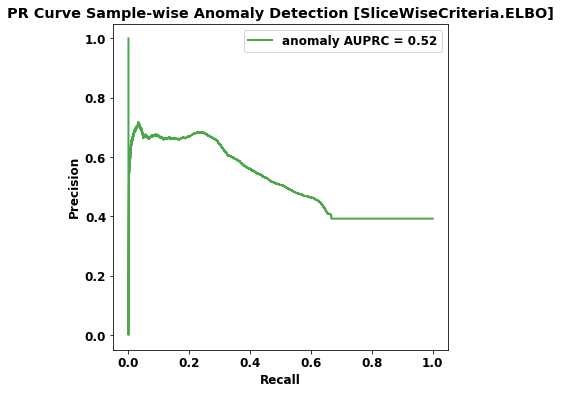

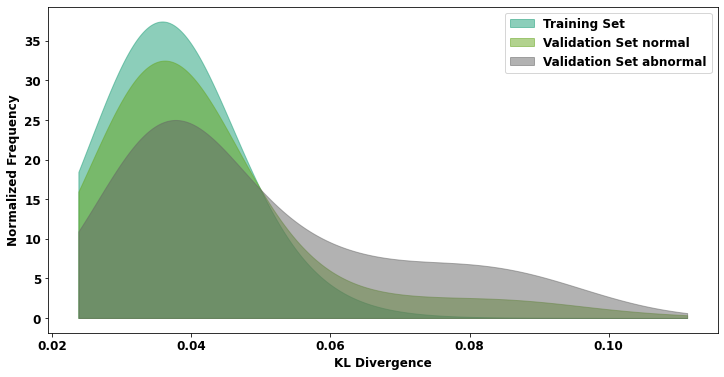

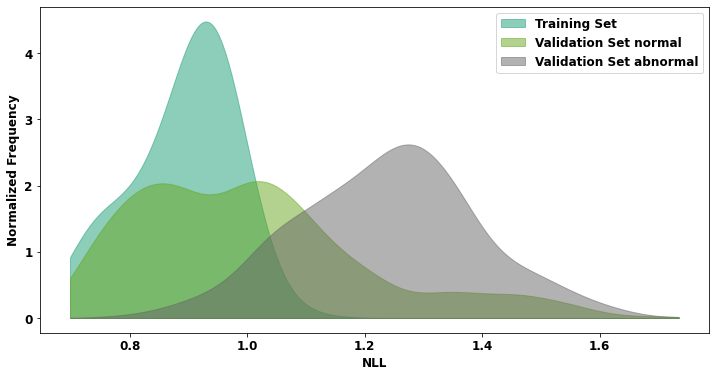

In [33]:
DO_SEGMENTATION = True
DO_ANOMALY_DETECTION = True
DO_HISTOGRAMS = True

results = {}

for dataloader, name in zip([brats_val_t2_dataloader, brats_val_t1_dataloader],
                            ['BraTS T2', 'BraTS T1']):
    result = run_evaluation_pipeline(model, 
                                        camcan_train_dataloader, 
                                        dataloader, 
                                        eval_cfg, 
                                        best_threshold=0.9,
                                        run_segmentation=DO_SEGMENTATION, 
                                        run_anomaly_detection=DO_ANOMALY_DETECTION, 
                                        run_histograms=DO_HISTOGRAMS)
    results[name] = result

In [15]:
from uncertify.evaluation.inference import SliceWiseCriteria

In [28]:
for name, result in results.items():
    print(name)
    for res in result.slice_anomaly_results.results:
        print(res.__dict__)

BraTS T2
{'au_prc': 0.7483397789908621, 'au_roc': 0.7004629629629628, 'criteria': 'SliceWiseCriteria.REC_TERM'}
{'au_prc': 0.7483397789908621, 'au_roc': 0.7004629629629628, 'criteria': 'SliceWiseCriteria.KL_TERM'}
{'au_prc': 0.7483397789908621, 'au_roc': 0.7004629629629628, 'criteria': 'SliceWiseCriteria.ELBO'}
{'au_prc': 0.757574075409406, 'au_roc': 0.7068865740740741, 'criteria': 'SliceWiseCriteria.REC_TERM'}
{'au_prc': 0.757574075409406, 'au_roc': 0.7068865740740741, 'criteria': 'SliceWiseCriteria.KL_TERM'}
{'au_prc': 0.757574075409406, 'au_roc': 0.7068865740740741, 'criteria': 'SliceWiseCriteria.ELBO'}
{'au_prc': 0.5658536432777327, 'au_roc': 0.6775909681611435, 'criteria': 'SliceWiseCriteria.REC_TERM'}
{'au_prc': 0.5658536432777327, 'au_roc': 0.6775909681611435, 'criteria': 'SliceWiseCriteria.KL_TERM'}
{'au_prc': 0.5658536432777327, 'au_roc': 0.6775909681611435, 'criteria': 'SliceWiseCriteria.ELBO'}
{'au_prc': 0.5195981930235931, 'au_roc': 0.6731047453703703, 'criteria': 'SliceWis